# Extracting Deep Features

In [23]:
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [24]:
cats=next(os.walk('.'))[1][1:]

In [25]:
cats = ['proc_anger', 'proc_fear', 'proc_happy', 'proc_neutral', 'proc_sad']

In [26]:
!pwd

/home/charles/Dropbox/ACHRI_faces


In [27]:
import tarfile

### Extract archives outside of Dropbox folder

In [28]:
td='../../ACHRI_extracted/'
try:
    os.mkdir(td)
except FileExistsError:
    pass
modes=['emo', 'vgg']
list_files=dict()
list_files[modes[0]]={}
list_files[modes[1]]={}

for cat in cats:
    for mode in modes:
        tar = tarfile.open('./'+cat+'/feats/'+mode+'.npy.tar.gz', 'r:gz')
        tar.extractall(td)
        os.rename(td+mode+'.npy', td+mode+'_'+cat+'.npy')
        tar.close()
        list_files[mode][cat] = td+mode+'_'+cat+'.npy'

In [29]:
list_files['emo'].keys()

dict_keys(['proc_sad', 'proc_anger', 'proc_happy', 'proc_fear', 'proc_neutral'])

In [30]:
list_files['vgg'].keys()

dict_keys(['proc_sad', 'proc_anger', 'proc_happy', 'proc_fear', 'proc_neutral'])

In [31]:
cats

['proc_anger', 'proc_fear', 'proc_happy', 'proc_neutral', 'proc_sad']

In [32]:
# will use one hot vectors for targets
labels=np.identity(5)
labels

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

### Load `emo`

In [33]:
emo_train=np.zeros((5000, 4048+5))
emo_test=np.zeros((5000, 4048+5))
c_train=0
c_test=0
tot=0
for idx, cat in enumerate(cats):
    arr=np.load(list_files['emo'][cat])
    tot+=arr.shape[0]
    lim=int(0.80*arr.shape[0])
    
    
    train=arr[:lim,:]
    test=arr[lim:,:]
    tlim=test.shape[0]
    
    emo_train[c_train:c_train+lim,:-5] = train
    emo_test[c_test:c_test+tlim,:-5] = test
    
    emo_train[c_train:c_train+lim,-5:] = labels[idx,:]
    emo_test[c_test:c_test+tlim,-5:] = labels[idx,:]
    
    c_train+=lim
    c_test+=tlim

emo_train=emo_train[:c_train,:]
emo_test=emo_test[:c_test,:]

##### Sanity Checks

In [34]:
print(emo_train.shape)
print(emo_test.shape)
print('%.2f --- should be close to 0.80'% (emo_train.shape[0]/float(emo_train.shape[0]+emo_test.shape[0])))
print(emo_train[0][-5:]) # check encoding
assert tot==emo_train.shape[0]+emo_test.shape[0] # have we lost any data?

(3079, 4053)
(772, 4053)
0.80 --- should be close to 0.80
[ 1.  0.  0.  0.  0.]


### Load `vgg`

In [35]:
vgg_train=np.zeros((5000, 4096+5))
vgg_test=np.zeros((5000, 4096+5))
c_train=0
c_test=0
tot=0
for idx, cat in enumerate(cats):
    arr=np.load(list_files['vgg'][cat])
    tot+=arr.shape[0]
    lim=int(0.80*arr.shape[0])
    
    
    train=arr[:lim,:]
    test=arr[lim:,:]
    tlim=test.shape[0]
    
    vgg_train[c_train:c_train+lim,:-5] = train
    vgg_test[c_test:c_test+tlim,:-5] = test
    
    vgg_train[c_train:c_train+lim,-5:] = labels[idx,:]
    vgg_test[c_test:c_test+tlim,-5:] = labels[idx,:]
    
    c_train+=lim
    c_test+=tlim

vgg_train=vgg_train[:c_train,:]
vgg_test=vgg_test[:c_test,:]

#### Sanity Checks

In [36]:
print(vgg_train.shape)
print(vgg_test.shape)
print('%.2f --- should be close to 0.80'% (vgg_train.shape[0]/float(vgg_train.shape[0]+vgg_test.shape[0])))
print(vgg_train[0][-5:]) # check encoding
assert tot==vgg_train.shape[0]+vgg_test.shape[0] # have we lost any data?

(3079, 4101)
(772, 4101)
0.80 --- should be close to 0.80
[ 1.  0.  0.  0.  0.]


### All good and (almost) ready to go!

In [37]:
# merge features from both models
train=np.concatenate((vgg_train[:,:-5], emo_train[:,:]),axis=1)
test =np.concatenate((vgg_test[:,:-5], emo_test[:,:]),axis=1)
assert train.shape[1] == 4096+4048+5
train.shape, test.shape

((3079, 8149), (772, 8149))

In [38]:
# shuffle rows
train= np.random.permutation(train)
test = np.random.permutation(test)

In [39]:
train # apparently it's pretty sparse so let's check do some PCA

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  9.90073967,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

### PCA

In [40]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [41]:
trainX, trainY = train[:,:-5], train[:,-5:]
testX, testY = test[:,:-5], test[:,-5:]
trainX.shape, trainY.shape, test.shape, test.shape

((3079, 8144), (3079, 5), (772, 8149), (772, 8149))

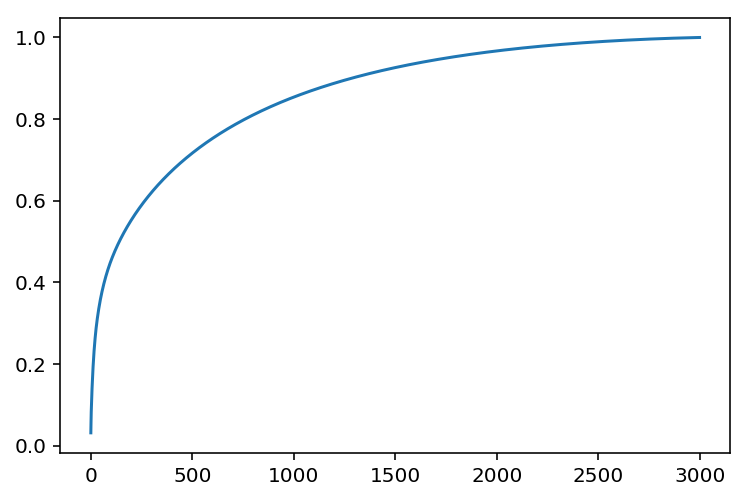

In [55]:
pca=PCA(n_components=3000)
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca)])
trainX_pcaed=pipeline.fit_transform(trainX)
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [56]:
print('New data shape is %dx%d'%trainX_pcaed.shape)
print('Amount of variance explained = %.10f'%  np.sum(pca.explained_variance_ratio_))

New data shape is 3079x3000
Amount of variance explained = 0.9997185066


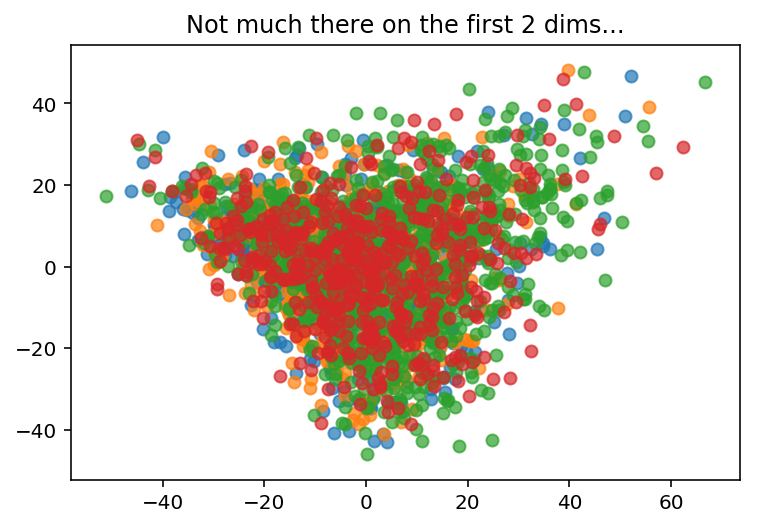

In [44]:
for i in range(4):
    _X, _Y = trainX_pcaed[np.argmax(trainY, axis=1)==i][:,0], trainX_pcaed[np.argmax(trainY, axis=1)==i][:,1]
    plt.scatter(_X, _Y, alpha=0.7)
plt.title('Not much there on the first 2 dims...')

### SVM

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [53]:
trainY_argmax=np.argmax(trainY, axis=1)

pca=PCA(n_components=400)
clf = SVC(C=1.0, gamma='auto')
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca), ('svc', clf)])
fit=pipeline.fit(trainX, trainY_argmax)

pred_test=pipeline.predict(testX)

np.sum(pred_test == np.argmax(testY, axis=1))/pred_test.shape[0]

0.32642487046632124

In [54]:
pred_train=pipeline.predict(trainX)
np.sum(pred_train == np.argmax(trainY, axis=1))/pred_train.shape[0]

0.98830789217278336

             precision    recall  f1-score   support

          0       0.25      0.22      0.23       139
          1       0.27      0.26      0.26       132
          2       0.42      0.76      0.54       258
          3       0.31      0.06      0.10       132
          4       0.21      0.05      0.09       111

avg / total       0.31      0.35      0.30       772



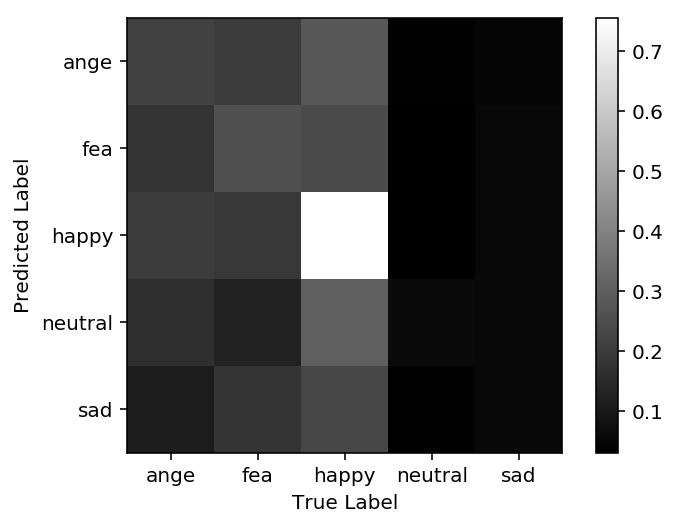

In [47]:
y_true, y_pred = np.argmax(testY, axis=1), pipeline.predict(testX)
print(classification_report(y_true, y_pred))

cm=confusion_matrix(y_true, y_pred)
plt.imshow(cm/np.sum(cm, axis=1), cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
cats_labs = [cat.strip('proc_') for cat in cats]
plt.xticks([0,1,2,3,4], cats_labs)
plt.yticks([0,1,2,3,4], cats_labs);

In [32]:
np.save('charles_true.npy', y_true)
np.save('charles_pred.npy', y_pred)